In [ ]:
# Import the torch modules
import torch
import torch.optim as optim
import torch.nn as nn

# Torch.nn
PyTorch has a whole submodule dedicated to neural networks, called **torch.nn**. It contains the building blocks needed to create all sorts of neural network architectures.

A PyTorch module is a Python class deriving from the nn.Module base class.
> - A module can have one or more Parameter instances as attributes, which are tensors whose values are optimized during the training process (think w and b in our linear model).
> - A module can also have one or more submodules (subclasses of nn.Module) as attributes, and it will be able to track their parameters as well. (for example, a subclass of nn.Module called nn.Linear)

## Using "\_\_call\_\_" rather than "forward"

All PyTorch-provided subclasses of nn.Module have their \_\_call\_\_ method defined. This allows us to instantiate an nn.Linear and call it as if it was a function.

> - Calling an instance of nn.Module with a set of arguments ends up calling a method named forward with the same arguments. The forward method is what executes the forward computation, while \_\_call\_\_() does other rather important chores before and after calling forward.

Here’s the implementation of Module.\_\_call\_\_()

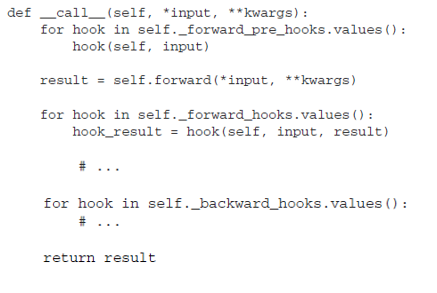

So, it is technically possible to call forward directly, and it will produce the same output as __call__, but this should not be done from user code:

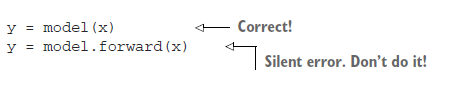

In [ ]:
# prepare datasets
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]

# To accommodate multiple samples, modules expect the zeroth dimension of the input to be the number of samples in the batch
# we would need to add an extra dimension to turn that 1D tensor into a matrix with samples in the rows and features in the columns.
t_c = torch.tensor(t_c).unsqueeze(1) # Adds the extra dimension at axis 1
t_u = torch.tensor(t_u).unsqueeze(1) #
print('t_u.shape -->', t_u.shape)

n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

print('t_un_train.shap -->', t_un_train.shape)
print('t_un_val.shape -->', t_un_val.shape)

t_u.shape --> torch.Size([11, 1])
t_un_train.shap --> torch.Size([9, 1])
t_un_val.shape --> torch.Size([2, 1])


In [ ]:
# create a linear nn submodule
linear_model = nn.Linear(1, 1) #The arguments are input size, output size, and bias defaulting to True
print(linear_model(t_un_val))

tensor([[4.8538],
        [3.6331]], grad_fn=<AddmmBackward0>)


## Get parameters

.parameters() method of nn.Model

PyTorch offers a quick way to determine how many parameters a model has through the parameters() method of nn.Model (the same method we use to provide the parameters to the optimizer). To find out how many elements are in each tensor instance, we can call the numel method. Summing those gives us our total count.

Depending on our use case, counting parameters might require us to check whether a parameter has requires_grad set to True, as well. We might want to differentiate the number of trainable parameters from the overall model size.

In [ ]:
print(linear_model.weight)
print(linear_model.bias)
print()

# or .parameters() eturns an iterator over module parameters. This is typically passed to an optimizer.
print(linear_model.parameters())
print()

for param in linear_model.parameters():
  print(param)
  print(param.numel())  # check number of parameters per layer
print()

list(linear_model.parameters())

# check total number of parameters of the model
print(sum(param.numel() for param in linear_model.parameters()))
print()

# check total number of trainable parameters of the model
print(sum(param.numel() for param in linear_model.parameters() if param.requires_grad))

Parameter containing:
tensor([[0.9248]], requires_grad=True)
Parameter containing:
tensor([0.3316], requires_grad=True)

<generator object Module.parameters at 0x7d211d986810>

Parameter containing:
tensor([[0.9248]], requires_grad=True)
1
Parameter containing:
tensor([0.3316], requires_grad=True)
1

2

2


In [ ]:
print(linear_model.named_parameters())
print()

for name, param in linear_model.named_parameters():
  print(name, '---', param)
print()

list(linear_model.named_parameters())

<generator object Module.named_parameters at 0x7d211d9867a0>

weight --- Parameter containing:
tensor([[0.9248]], requires_grad=True)
bias --- Parameter containing:
tensor([0.3316], requires_grad=True)



[('weight',
  Parameter containing:
  tensor([[0.9248]], requires_grad=True)),
 ('bias',
  Parameter containing:
  tensor([0.3316], requires_grad=True))]

In [ ]:
numel_list = [param.numel() for param in linear_model.parameters()]

sum(numel_list), numel_list

(2, [1, 1])

In [ ]:
numel_list = [param.numel() for param in linear_model.parameters() if param.requires_grad == True]

sum(numel_list), numel_list

(2, [1, 1])

## Built-in loss functions in Torch.nn
Torch.nn comes with several common loss functions, among them nn.MSELoss (MSE stands for Mean Square Error), which is exactly what we defined earlier as our loss_fn.

https://pytorch.org/docs/stable/nn.html#loss-functions

In [ ]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)

        with torch.no_grad():
          t_p_val = model(t_u_val)
          loss_val = loss_fn(t_p_val, t_c_val)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

In [ ]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), # note: we are no longer using our hand-written loss function from earlier
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 371.5647, Validation loss 79.3547
Epoch 1000, Training loss 3.9599, Validation loss 6.0840
Epoch 2000, Training loss 3.1965, Validation loss 2.9894
Epoch 3000, Training loss 3.1717, Validation loss 2.5498

Parameter containing:
tensor([[5.2346]], requires_grad=True)
Parameter containing:
tensor([-16.3231], requires_grad=True)


In [ ]:
# for comparsion, the following recall the hand-written loss function from earlier
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

linear_model = nn.Linear(1, 1) # <1>
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    model = linear_model,
    loss_fn = loss_fn,
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 179.6968, Validation loss 20.9945
Epoch 1000, Training loss 4.0450, Validation loss 6.3202
Epoch 2000, Training loss 3.1993, Validation loss 3.0188
Epoch 3000, Training loss 3.1718, Validation loss 2.5547

Parameter containing:
tensor([[5.2337]], requires_grad=True)
Parameter containing:
tensor([-16.3180], requires_grad=True)


# nn.Sequential()

Let’s build the simplest possible neural network: a linear module, followed by an activation function, feeding into another linear module.

Torch.nn provides a simple way to concatenate modules through the **nn.Sequential** container.

Our simplest neural network in two views. Left: beginner’s version. Right: higher-level version
![18.PNG](attachment:f7169ce0-4c8e-4b21-a517-a9cad4813482.PNG)


In [ ]:
seq_model = nn.Sequential(
            nn.Linear(1, 13), # We chose 13 arbitrarily. We wanted a number that was a different size from the other tensor shapes we have floating around.
            nn.Tanh(), # activation function of the 1st layer
            nn.Linear(13, 1) # This 13 must match the first size, however
            )

# check the structure
print(seq_model)
print()

# check parameters
for param in seq_model.named_parameters():
    print(param)

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

('0.weight', Parameter containing:
tensor([[-0.3367],
        [ 0.2452],
        [-0.5171],
        [ 0.4187],
        [ 0.9050],
        [ 0.1457],
        [ 0.2823],
        [ 0.7389],
        [ 0.7285],
        [-0.2354],
        [-0.1077],
        [ 0.7370],
        [-0.1791]], requires_grad=True))
('0.bias', Parameter containing:
tensor([-0.1395, -0.2340,  0.1654, -0.0889,  0.7981, -0.9329,  0.3720, -0.2368,
        -0.2889, -0.9685, -0.1207, -0.3851,  0.8940], requires_grad=True))
('2.weight', Parameter containing:
tensor([[ 0.0042,  0.1064,  0.2557, -0.2769,  0.0942,  0.2652, -0.1662,  0.1137,
          0.0233, -0.1834, -0.1053, -0.1486, -0.0704]], requires_grad=True))
('2.bias', Parameter containing:
tensor([0.0792], requires_grad=True))


In [ ]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) # <1>

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print('output', seq_model(t_un_val))
print('answer', t_c_val)

Epoch 1, Training loss 225.8185, Validation loss 34.4170
Epoch 1000, Training loss 5.0477, Validation loss 1.6821
Epoch 2000, Training loss 4.9979, Validation loss 4.4502
Epoch 3000, Training loss 3.3110, Validation loss 2.6887
Epoch 4000, Training loss 2.6271, Validation loss 2.1223
Epoch 5000, Training loss 2.3243, Validation loss 1.9562
output tensor([[7.6532],
        [1.9738]], grad_fn=<AddmmBackward0>)
answer tensor([[8.0000],
        [0.5000]])


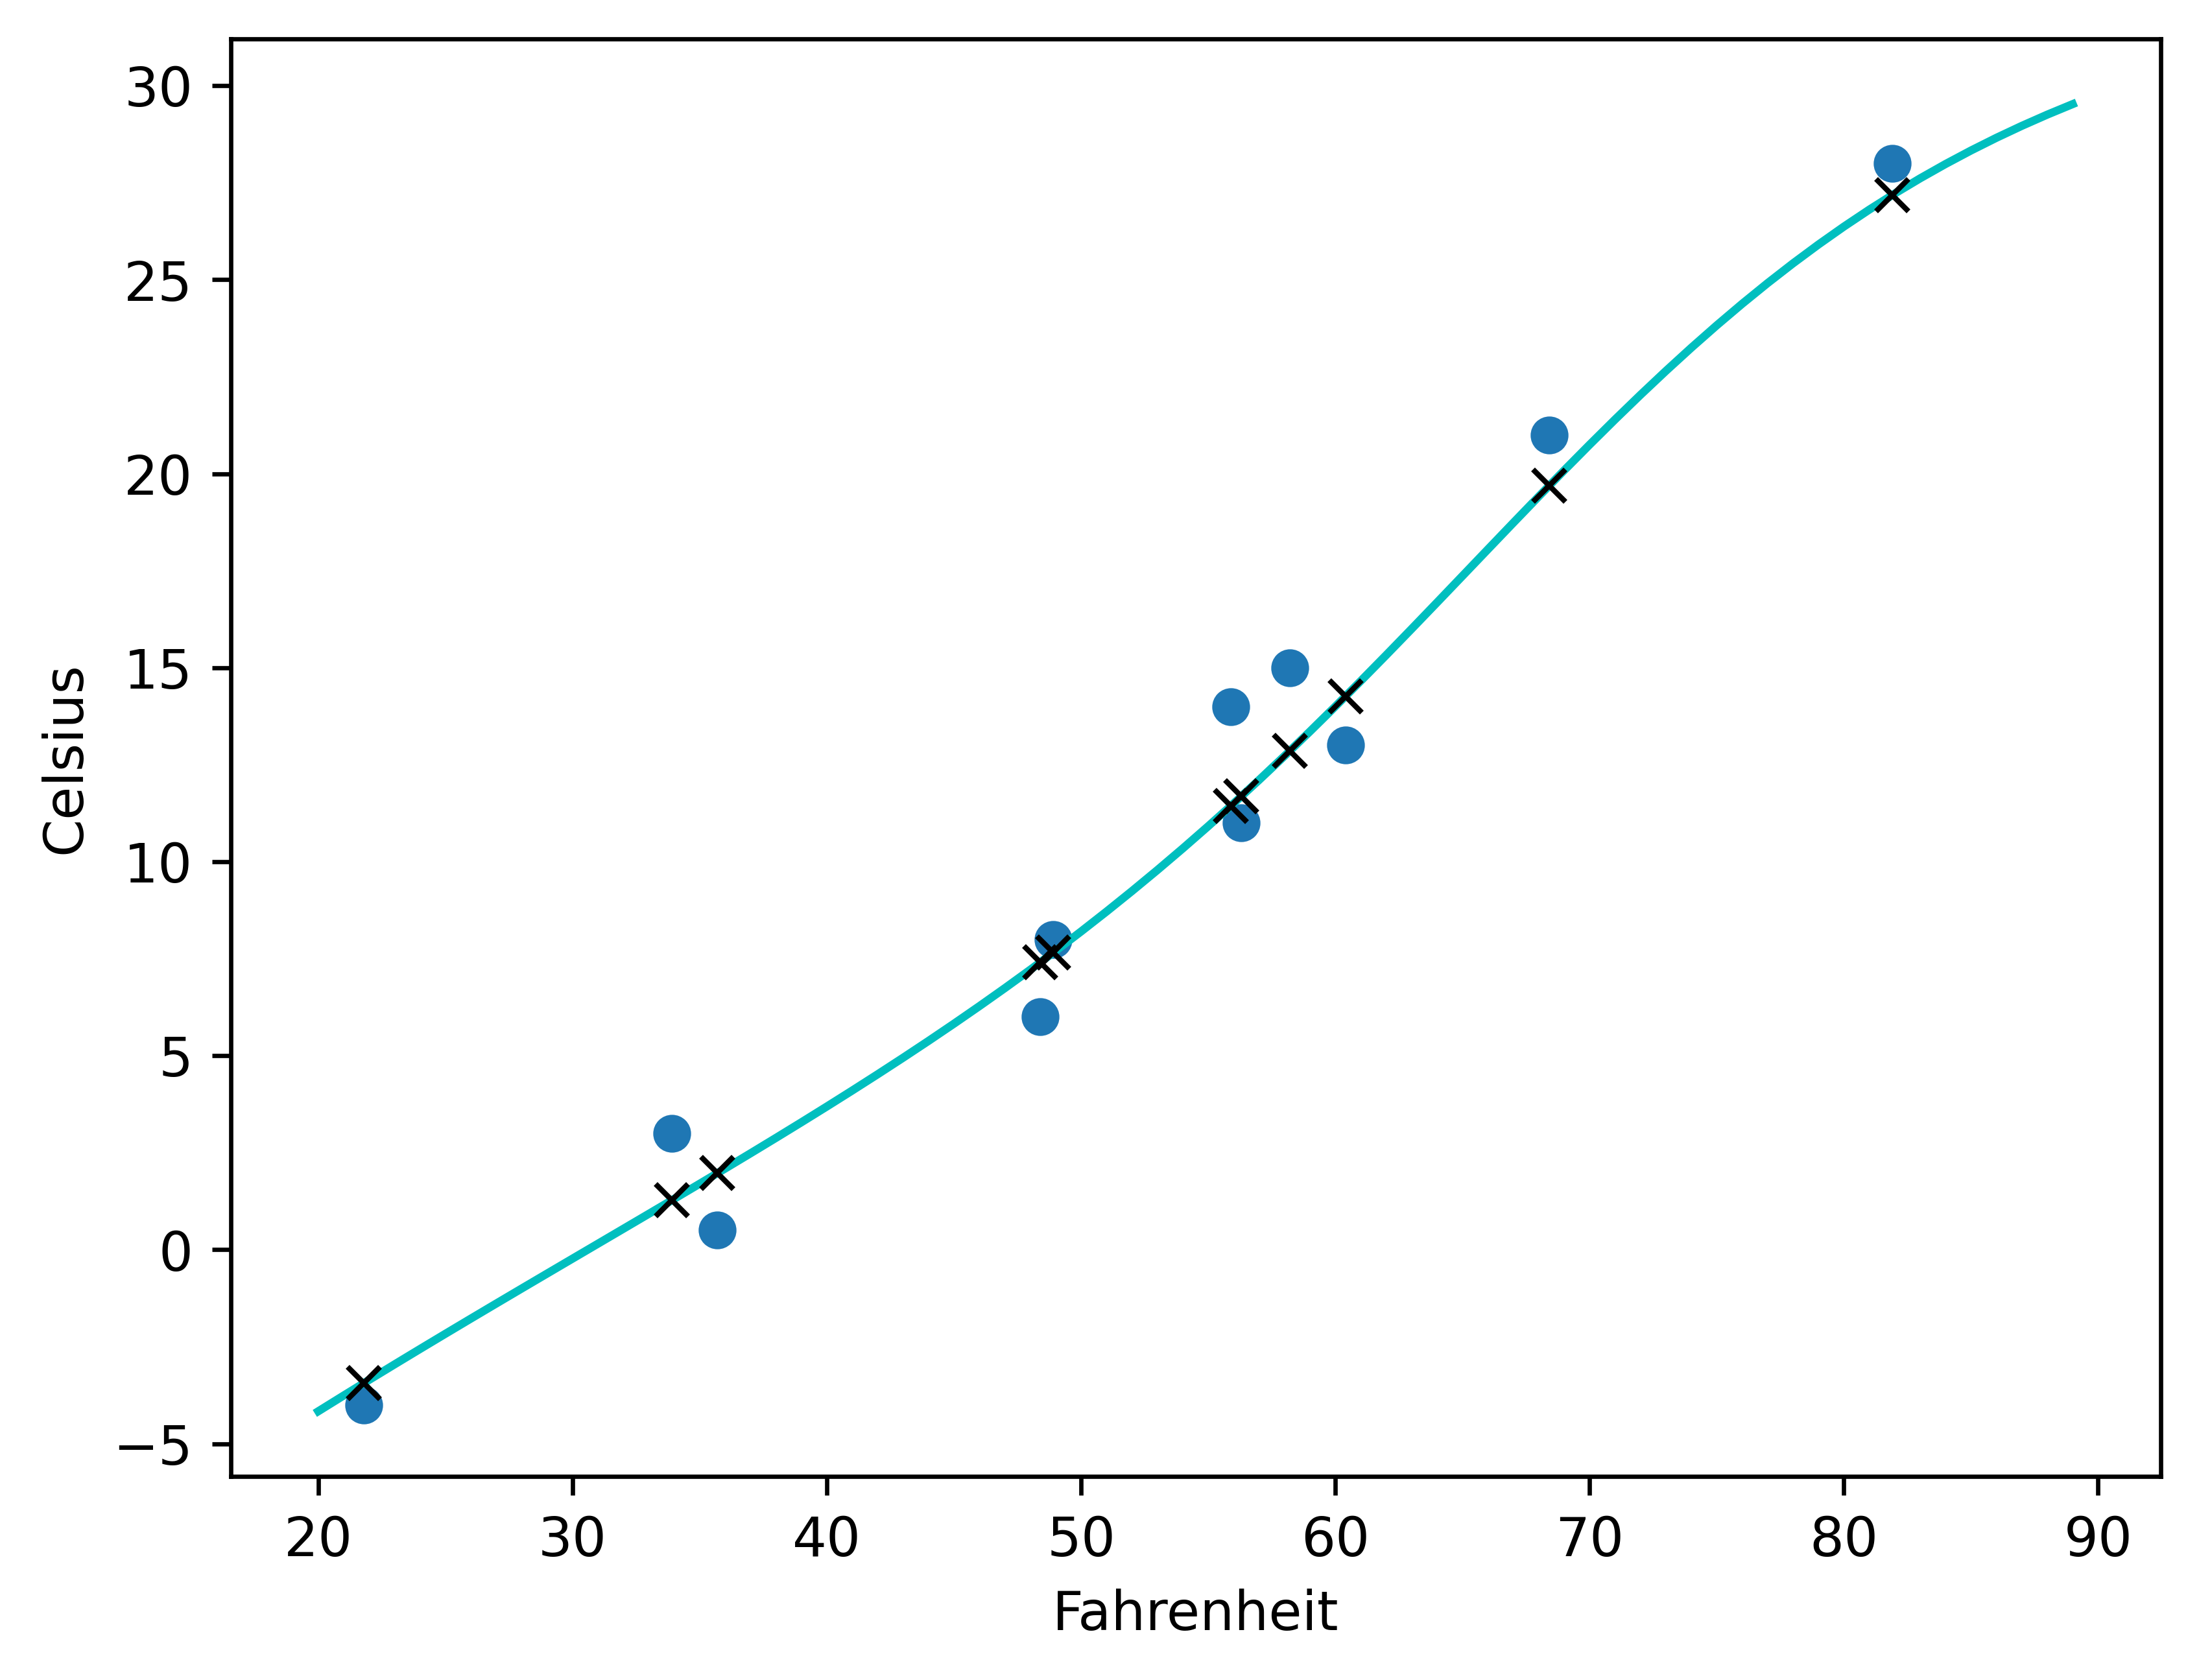

In [ ]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

# Note: __call__ in Python
Python has a set of built-in methods and __call__ is one of them. The __call__ method enables Python programmers to write classes where the instances behave like functions and can be called like a function. When the instance is called as a function; if this method is defined, x(arg1, arg2, ...) is a shorthand for x.__call__(arg1, arg2, ...).

https://www.geeksforgeeks.org/__call__-in-python/


In [ ]:
class Example:
    def __init__(self):
        print("Instance Created")

    # Defining __call__ method
    def __call__(self):
        print("Instance is called via special method")

# Instance created
e = Example()

# __call__ method will be called
e()

Instance Created
Instance is called via special method


In [ ]:
class Product:
    def __init__(self):
        print("Instance Created")

    # Defining __call__ method
    def __call__(self, a, b):
        print(a * b)

# Instance created
ans = Product()

# __call__ method will be called
ans(10, 20)

Instance Created
200
